# Modelling

In [1]:
from fsds.imports import * 

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist, TweetTokenizer

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
import string

fsds v0.2.27 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding 

In [2]:
df = pd.read_csv('data/intro_df.csv')
df = df.drop(columns = ['id', 'product'], axis = 1)
df

,text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for iPad 2 also. They...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri SXSW: Marissa Ma...,positive
...,...,...
9088,Ipad everywhere. SXSW {link},positive
9089,"Wave, buzz... RT @mention We interrupt your re...",neutral
9090,"Google's Zeiger, a physician never reported po...",neutral
9091,Some Verizon iPhone customers complained their...,neutral


In [3]:
stops = (stopwords.words('english') +
        list(string.punctuation) +
        ['“','”','...',"''",'’','``'] + 
        ["rt", "'s", "n't", "'re", "'m", "'ll", "--", "..",'link', 'mention', 'austin', 'SXSW', 'sxsw', 'quot'] +
        [str(i) for i in range(0, 10)])

## 1. Classifying tweets on existence of sentiment
We will first construct a binary classifier that splits our data into tweets that contain sentiment and tweets that do not have sentiment. For validating this stage of modelling, we will be most concerned with 

In [4]:
# we construct our target variable, 1 if a tweet has sentiment, 0 if it does not.

has_sentiment_list = []

for i in df['sentiment']:
    if i == 'positive':
        has_sentiment_list.append(1)
    elif i == 'negative':
        has_sentiment_list.append(1)
    else:
        has_sentiment_list.append(0)
        
df['has_sentiment'] = has_sentiment_list

In [5]:
df = df.dropna()

In [6]:
X = df['text']
y = df['has_sentiment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [8]:
X_train.shape

(6819,)

In [9]:
y_train.value_counts(1)

0    0.613726
1    0.386274
Name: has_sentiment, dtype: float64

In [10]:
# we tokenize

tweet_tokenizer = nltk.TweetTokenizer(preserve_case=False)
tweet_vectorizer = TfidfVectorizer(tokenizer = tweet_tokenizer.tokenize,
                                 stop_words = stops,
                                 decode_error = 'ignore',
                                 strip_accents = "ascii")
# and vectorize

X_train_tfidf = tweet_vectorizer.fit_transform(X_train)
X_test_tfidf = tweet_vectorizer.transform(X_test)


In [11]:
# we need to address our class imbalance, and will do so through SMOTE

smote = SMOTE()

X_train_tfidf_sm, y_train_sm = smote.fit_sample(X_train_tfidf, y_train)


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [12]:
# we initialize our Multinomial Naive Bayes Classifier

NB = MultinomialNB()
NB.fit(X_train_tfidf_sm, y_train_sm)

MultinomialNB()

In [13]:

y_pred_sm = NB.predict(X_test_tfidf)

In [14]:
def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                  scorer=False, classes = None):
    """Quick/simple classification model evaluatiin"""

    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues',display_labels=classes)
    plt.show()

#### Naive Bayes Smoted

              precision    recall  f1-score   support

  No Emotion       0.75      0.62      0.68      1359
     Emotion       0.55      0.68      0.61       914

    accuracy                           0.65      2273
   macro avg       0.65      0.65      0.64      2273
weighted avg       0.67      0.65      0.65      2273



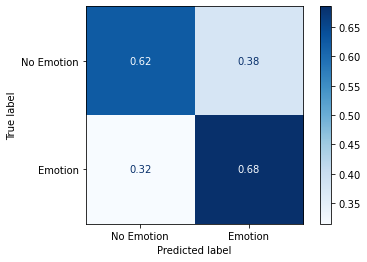

In [15]:
evaluate_model(y_test, y_pred_sm, X_test_tfidf, clf=NB, classes = ['No Emotion', 'Emotion'])

#### Naive Bayes Non-Smoted

              precision    recall  f1-score   support

  No Emotion       0.67      0.89      0.77      1359
     Emotion       0.69      0.35      0.47       914

    accuracy                           0.68      2273
   macro avg       0.68      0.62      0.62      2273
weighted avg       0.68      0.68      0.65      2273



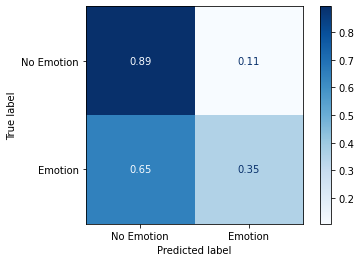

In [16]:
NB.fit(X_train_tfidf, y_train)
y_pred = NB.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, X_test_tfidf, clf = NB, classes = ['No Emotion', 'Emotion'])

The comparison here is to be expected. Because our smoted word vectors are balanced, there is some balance between our errors. Conversely, without smoting our data, we can see that our classifier is biased toward classifying a tweet as having no emotion, which is an issue, because the entire point of this model is to provide another dataset to be further classified between positive and negative emotion. Thus, we should try to avoid classifying tweets as having no sentiment, because this would remove them from the workflow and provide less information to our next model. 

In [17]:
# we initialize our Random Forest classifier
RF = RandomForestClassifier()
RF.fit(X_train_tfidf_sm, y_train_sm)

RandomForestClassifier()

In [18]:

y_pred_sm = RF.predict(X_test_tfidf)

#### Random Forest Smoted

              precision    recall  f1-score   support

  No Emotion       0.71      0.77      0.74      1359
     Emotion       0.62      0.54      0.58       914

    accuracy                           0.68      2273
   macro avg       0.67      0.66      0.66      2273
weighted avg       0.68      0.68      0.68      2273



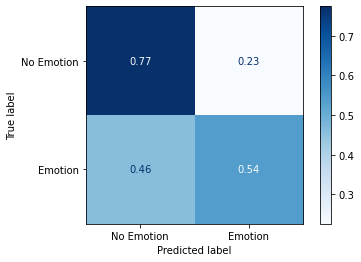

In [19]:
evaluate_model(y_test, y_pred_sm, X_test_tfidf, clf=RF, classes = ['No Emotion', 'Emotion'])

#### Random Forest Non-Smoted

              precision    recall  f1-score   support

  No Emotion       0.70      0.84      0.76      1359
     Emotion       0.66      0.46      0.54       914

    accuracy                           0.69      2273
   macro avg       0.68      0.65      0.65      2273
weighted avg       0.68      0.69      0.68      2273



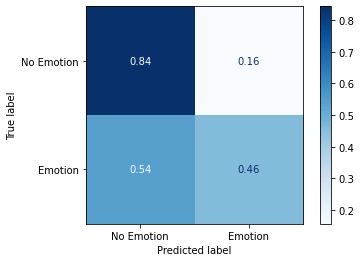

In [20]:
RF2 = RandomForestClassifier()
RF2.fit(X_train_tfidf, y_train)
y_pred = RF2.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, X_test_tfidf, clf = RF2, classes = ['No Emotion', 'Emotion'])

Well this is just terrible. 

In [21]:
# using Gausssian NB
GNB = GaussianNB()

#### Gaussian Naive Bayes

              precision    recall  f1-score   support

  No Emotion       0.68      0.38      0.49      1359
     Emotion       0.45      0.74      0.55       914

    accuracy                           0.52      2273
   macro avg       0.56      0.56      0.52      2273
weighted avg       0.59      0.52      0.52      2273



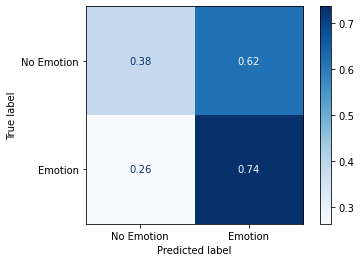

In [25]:
GNB.fit(X_train_tfidf.toarray(), y_train)
y_pred = GNB.predict(X_test_tfidf.toarray())
evaluate_model(y_test, y_pred, X_test_tfidf.toarray(), clf = GNB, classes = ['No Emotion', 'Emotion'])

 So, while a Gaussian Naive Bayes estimator performs best on tweets that contain sentiment, Multinomial NB is better suited to 
 classifying tweets that have no sentiment. Let's forget random forest happened. For our purposes, which will be better fulfilled with a larger pool of tweets
 classified as sentimental, we will be continuing with our Gaussian Naive Bayes.

## 2. Classifying Tweets as Positive or Negative

Now we build a model that is able to distinguish between positive and negative tweets, assuming that we have a dataset that contains exclusively negative and postive tweets, no neutral tweets. In general, it is more important to correctly classify negative sentiment over positive sentiment, because a business is always looking for ways to improve. As such, we will be prioritizing accuracy during this phase of modelling. 

In [26]:
df_sentiment = pd.read_csv('data/sentimental_df.csv')
df = df_sentiment.drop(columns = ['id', 'id.1', 'product', 'is_google', 'is_apple', 'has_sentiment', 'sentiment'])
df

,text,pos_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1.0
2,@swonderlin Can not wait for iPad 2 also. They...,1.0
3,@sxsw I hope this year's festival isn't as cra...,0.0
4,@sxtxstate great stuff on Fri SXSW: Marissa Ma...,1.0
...,...,...
3186,@mention your PR guy just convinced me to swit...,1.0
3187,&quot;papyrus...sort of like the ipad&quot; - ...,1.0
3188,Diller says Google TV &quot;might be run over ...,0.0
3189,I've always used Camera+ for my iPhone b/c it ...,1.0


In [37]:
X = df['text']
y = df['pos_sentiment']

sum(y), len(y) # again, very strong class imbalance. Much stronger than in our prior model. 

(2672.0, 3191)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [39]:
tweet_tokenizer = nltk.TweetTokenizer(preserve_case=False)
tweet_vectorizer = TfidfVectorizer(tokenizer = tweet_tokenizer.tokenize,
                                 stop_words = stops,
                                 decode_error = 'ignore',
                                 strip_accents = "ascii")

X_train_tfidf = tweet_vectorizer.fit_transform(X_train)
X_test_tfidf = tweet_vectorizer.transform(X_test)

In [40]:
# we initialize our models

NB = MultinomialNB()
GNB = GaussianNB()
RF = RandomForestClassifier(n_estimators = 100)

#### Naive Bayes

              precision    recall  f1-score   support

    Positive       1.00      0.04      0.08       125
    Negative       0.85      1.00      0.92       673

    accuracy                           0.85       798
   macro avg       0.92      0.52      0.50       798
weighted avg       0.87      0.85      0.79       798



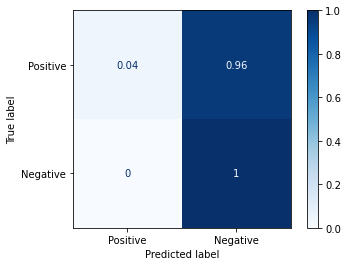

In [42]:
# Naive Bayes
NB2 = MultinomialNB()
NB2.fit(X_train_tfidf, y_train)
y_pred = NB2.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, X_test_tfidf, clf = NB2, classes = ['Positive', 'Negative'])

#### Gaussian Naive Bayes

              precision    recall  f1-score   support

    Positive       0.33      0.47      0.39       125
    Negative       0.89      0.82      0.85       673

    accuracy                           0.76       798
   macro avg       0.61      0.65      0.62       798
weighted avg       0.80      0.76      0.78       798



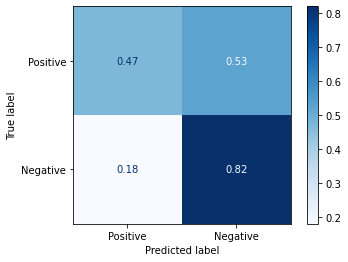

In [43]:
# Gaussian Naive Bayes()
GNB.fit(X_train_tfidf.toarray(), y_train)
y_pred = GNB.predict(X_test_tfidf.toarray())
evaluate_model(y_test, y_pred, X_test_tfidf.toarray(), clf = GNB, classes = ['Positive', 'Negative'])

#### Random Forest

              precision    recall  f1-score   support

    Positive       0.81      0.21      0.33       125
    Negative       0.87      0.99      0.93       673

    accuracy                           0.87       798
   macro avg       0.84      0.60      0.63       798
weighted avg       0.86      0.87      0.83       798



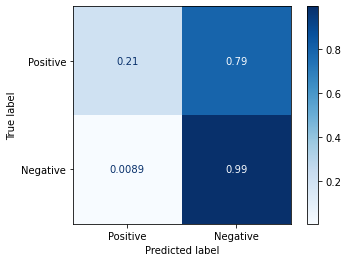

In [45]:
# Random Forest
RF.fit(X_train_tfidf, y_train)
y_pred = RF.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, X_test_tfidf, clf = RF, classes = ['Positive', 'Negative'])

According to weighted F1 scores, our Random Forest classifier performed best in this phase, and also was extremely accurate in classifying negative tweets, which lends to a great accuracy score of 87%. 

# Modelling Conclusions

We broke our modelling process into two steps; first, we classified our tweets on the existence of sentiment, splitting between neutral tweets and positive/negative tweets. Then, we classifed based upon positive or negative sentiment. We found that for classifying sentiment existence, Gaussian Naive Bayes performed best for our purposes, and for classifying positivity or negativity, a Random Forest perfomed best. 

# Recommendations

Apple had a larger portion of negative reviews than Google, at 23% compared to Google’s 14%, we recommend that Apple investigate these tweets and attempt to gain more information on where this negativity comes from.	

Google should strive to have a greater share of tweets altogether. Apple was referenced twice as much during SXSW, so a greater marketing strategy may help in closing this gap. 

Being able to compare national tweet sentiment versus SXSW tweets sentiment would give us a baseline to compare to, and allow us to gain comparative information. 

# Further Work

We decided to complete a two-stage classification process due to the heavy class imbalance that existed in our data. By lumping positive and negative tweets together, we were able to address class imbalance in the initial model. By removing neutral tweets first, we were also able to address the fact that neutral tweets far outnumbered positive or negative tweets. Had we completed a mutliclassification model, it would have certainly been extremely biased toward neutral tweets. By collecting a more balanced dataset, we would be better able to construct more elegant models.

Also, our data was clearly collected from a small sample space. This is evidenced by the fact that many of the tweets mentioned SXSW, or Austin. This informed us that these tweets are collected from one small area, during a small time period. While this is not an issue if we are looking to only make a model that can predict sentiment based on this small sample space, the applications of such a model are limited. Instead, we should strive to collect data that represents our full sample space, or all of twitter, to build a model that can be applied in most situations. 